# Problem Set 1: Identification of CTCF Binding Sites with Convolutional Neural Nets

In this problem set, we will explore and experiment with a convolutional neural network for image classification. The data we will use for this problem set was created by Yuchun Guo, and contains approximately 5000 images generated by the read counts of CTCF binding sites. Your job will be to experiment with our convolutional net code below to classify the CTCF binding sites from random noise (*ETS1 sites? SP1 sites? Both? Should I just call it random noise?*). The raw data for this problem set can be found in *maps.chr1/*, but the code for preprocessing the data, building, and training the network will be provided below.

The figure below shows the architecture for LeNet-5, a convolutional network used to classify handwritten digits. It is very similar to the general network architecture typically used in image recognition problems. Two convolutional layers apply filters to the image to produce layers of feature maps, and those results are subsampled through pooling layers. The final layers of the network are fully connected, and lead to an output layer with one node for each of the classes the network is trying to detect. We will use a similar architecture for our network.

![](http://i.imgur.com/a2wAIeW.png =250x)

All the code you will need to work with is provided below. For submissions, we ask that you submit a single Jupyter notebook (overwriting on this one is fine) containing the completed problems and any additional data or writeup. You will be graded based on accuracy of your results and clarity of your writeup. However, since this is a class focused on biological research methods at its core, we value the readability and reproducibility of your results above performance. This means you will have to convince the graders that your results (good or bad) make sense and that you understand the material being taught. Do not be afraid to ask for help! We will be here during office hours or by appointment to help you out and guide you along the process.

## Problem 1: Convolutional Neural Net Understanding

Before we do any coding, it is important to get a high level understanding of how convolutional layers translate the original input into features for the network to learn. A convolutional layer is defined by a set of learnable filters. For example, in our data set, the images are 50x200x1 (where the 1 refers to the depth of our image - in RGB images, this would be 3) and our first convolutional layer has filters of size 5x5x1. During each forward pass, we slide this filter along the axes of a given input and compute dot products of the filter with the cross-section of the input. This produces an output layer of size 46x196x1, whose features that are then passed to the next layer of the network. Define the **receptive field** of a node as the size of the original image that contributes information to the node (so for the aforementioned filter, the receptive field is 5x5). With this information, answer the following questions:

* The **stride** of a convolutional filter is another hyperparameter that controls how far we slide the filter along the width and height of the image. The most common value for this hyperparameter is 1, which means that we move the filters one pixel at a time. However, some networks use larger stride values to lower the size of the output. If we took our previous 5x5x1 filter and changed the stride to be 3, what would the new receptive field of a node in the convolutional layer be? (Should be 35 x 135)
* Another hyperparameter of convolutional filters is **zero-padding**, which adds zeros to the border of the input. This is often used when a desired filter does not fully slide along the width or height, or to control the spatial size of the output (most commonly used to make the output size and the raw input size exactly the same). In this case, suppose we would like to use our 5x5x1 filter but preserve the shape of the input (i.e. we want our output layer to have size 50x200x1). What is the smallest amount of zero-padding along the height and width required to make this possible? (2x2 height x width)
* Most convolutional neural nets don't have just one convolutional layer, and our network is no different. In our network, the first convolutional layer applies a 5x5x1 filter to the image. Then, the second convolutional layer applies a second 5x5x1 filter to the output of the first layer. Suppose both layers have a stride of 1 and no zero-padding. What is the receptive field of a node in the output of the second convolutional layer? What does this suggest about building convolutional networks? Are more convolutional layers preferable?

#################


Provide your responses here



#################

Now, we will build and run the convolutional neural network. First, run the code below to load in the data and generate training and test sets. Since each input sequence is extremely large, we will only use a portion of the given data set. However, this should not affect the performance of our CNN.

In [1]:
# imports
import math
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf

In [2]:
data_dirs = ["./maps.chr1/DNase.CTCF.chr1.data.txt", "./maps.chr1/DNase.ETS1.chr1.data.txt"]
num_classes = 2
train_size = 2000
test_size = 500

train_data = []
train_labels = []
test_data = []
test_labels = []

def shuffle_in_unison(a, b):
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

class_num = 0
for d in data_dirs:
    data_array = []
    with open(d, 'r') as f:
        header = f.readline()[1:]
        split_header = header.split("\t")
        x_dim, y_dim = map(int, split_header)
        for line in f:
            splitline = line.split("\t")
            splitline = map(float, splitline)
            splitline = np.array(splitline)
            data_array.append(splitline)
    data_array = np.array(data_array)
    label_array = np.zeros((data_array.shape[0], num_classes))
    label_array[:, class_num] = 1

    train_data.append(data_array[:train_size])
    train_labels.append(label_array[:train_size])
    test_data.append(data_array[train_size:test_size + train_size])
    test_labels.append(label_array[train_size:test_size + train_size])

    class_num += 1

train_data = np.concatenate(train_data)
train_labels = np.concatenate(train_labels)
test_data = np.concatenate(test_data)
test_labels = np.concatenate(test_labels)

train_data, train_labels = shuffle_in_unison(train_data, train_labels)
test_data, test_labels = shuffle_in_unison(test_data, test_labels)

print 'Training set size: ', train_data.shape[0]
print 'Test set size: ', test_data.shape[0]

Training set size:  4000
Test set size:  1000


Now that the data is properly loaded, we will build our convolutional net using TensorFlow below. Before you run anything, take a little time to read over the architecture and answer the following questions:

* How many convolutional layers are there? What are their filter sizes, zero-padding values, and strides? (Check the TensorFlow documentation for *tf.nn.conv2d* to see what padding="SAME" means)
* How are we initializing the weight and bias matrices? Why might this be a good idea when building networks?
* What is the loss function? How is it being minimized?

#################


Provide your responses here



#################

In [3]:
# Factory methods for creating variables and layers

def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride=1):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')

def max_pool(x, stride=2, filter_size=2):
    return tf.nn.max_pool(x, ksize=[1, filter_size, filter_size, 1],
                        strides=[1, stride, stride, 1], padding='SAME')

def weight_decay_penalty(weights):
    return sum([tf.nn.l2_loss(w) for w in weights])

In [4]:
# Model hyperparameters

batch_size = 50
learning_rate = 0.01
conv1_filter_size = 5
conv1_depth = 8
conv2_filter_size = 5
conv2_depth = 16
fc_num_hidden = 64

keep_prob = 0.7 # set to < 1.0 to apply dropout, 1.0 to remove
weight_penalty = 0.01 # set to > 0.0 to apply weight penalty, 0.0 to remove

tf.reset_default_graph()

# Model definition begins here
train_x = tf.placeholder(tf.float32, shape=(None, x_dim*y_dim))
train_y = tf.placeholder(tf.float32, shape=(None, num_classes))

x_image = tf.reshape(train_x, [-1, x_dim, y_dim, 1])

W_conv1 = weight_variable([conv1_filter_size, conv1_filter_size, 1, conv1_depth])
b_conv1 = bias_variable([conv1_depth])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool(h_conv1)

conv1_feat_map_x = int(math.ceil(float(x_dim) / 2)) # stride
conv1_feat_map_y = int(math.ceil(float(y_dim) / 2)) # stride

W_conv2 = weight_variable([conv2_filter_size, conv2_filter_size, conv1_depth, conv2_depth])
b_conv2 = bias_variable([conv2_depth])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool(h_conv2)

conv2_feat_map_x = int(math.ceil(float(conv1_feat_map_x) / 2)) # stride
conv2_feat_map_y = int(math.ceil(float(conv1_feat_map_y) / 2)) # stride

W_fc1 = weight_variable([conv2_feat_map_x * conv2_feat_map_y * conv2_depth, fc_num_hidden])
b_fc1 = bias_variable([fc_num_hidden])

h_pool2_flat = tf.reshape(h_pool2, [-1, conv2_feat_map_x * conv2_feat_map_y * conv2_depth])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([fc_num_hidden, num_classes])
b_fc2 = bias_variable([num_classes])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, train_y))
loss = cross_entropy + weight_decay_penalty([W_fc1, W_fc2])*weight_penalty
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(train_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Now that you are familiar with our architecture, try running the original network as is, without any modifications. It should take about 10-15 minutes to train the network for 1600 steps. What do you notice about the final test set accuracy? What does this suggest about the network?

In [5]:
start = time.time()
num_epochs = 20

batches_per_epoch = int(math.ceil(len(train_data)/batch_size))
num_steps = int(num_epochs * batches_per_epoch)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
print 'Initializing variables...'

for step in xrange(num_steps):
    offset = (step * batch_size) % (train_data.shape[0] - batch_size)
    batch_x = train_data[offset:(offset + batch_size), :]
    batch_y = train_labels[offset:(offset + batch_size)]

    feed_dict = {train_x: batch_x, train_y: batch_y}
    _, batch_loss, batch_preds, batch_acc = sess.run([train_step, loss, 
                                                      correct_prediction, accuracy], 
                                                     feed_dict=feed_dict)

    if (step % 100 == 0):
        print ''
        print 'Batch loss at step %d: %f' % (step, batch_loss)
        print 'Training accuracy: %f' % batch_acc

test_acc = sess.run(accuracy, feed_dict={train_x: test_data, 
                                           train_y: test_labels})
print 'Test accuracy: %f' % test_acc

print "Training time: ", time.time() - start

Initializing variables...

Batch loss at step 0: 26.711195
Training accuracy: 0.380000

Batch loss at step 100: 25.979994
Training accuracy: 0.520000

Batch loss at step 200: 25.287273
Training accuracy: 0.700000

Batch loss at step 300: 24.810335
Training accuracy: 0.760000

Batch loss at step 400: 24.329487
Training accuracy: 0.720000

Batch loss at step 500: 23.810656
Training accuracy: 0.720000

Batch loss at step 600: 23.394106
Training accuracy: 0.780000

Batch loss at step 700: 22.941828
Training accuracy: 0.760000

Batch loss at step 800: 22.494431
Training accuracy: 0.740000

Batch loss at step 900: 21.958317
Training accuracy: 0.760000

Batch loss at step 1000: 21.486910
Training accuracy: 0.840000

Batch loss at step 1100: 21.196081
Training accuracy: 0.760000

Batch loss at step 1200: 20.733177
Training accuracy: 0.840000

Batch loss at step 1300: 20.259102
Training accuracy: 0.800000

Batch loss at step 1400: 19.859085
Training accuracy: 0.820000

Batch loss at step 1500: 

#################


Provide your responses here



#################

## Problem 2: Optimization

We will now explore several ways of improving the performance of our network. Test each one individually and discuss how your results were affected.

### Dropout

When the training set is small and the network is large, it can cause the nodes of a network to co-adapt and therefore overfit. At a high level, a possible result of this is that each node of a fully-connected layer could encode all the information for a single training point, leading to poor generalizability to unseen data. Dropout is a technique for addressing this problem, in which nodes and their connections are randomly removed during training. In TensorFlow, this is encoded using the *tf.nn.dropout* function. We have already implemented a dropout layer in our network, but we have set *keep_prob* (the probability that a node is kept in the layer) to 1.0. Modify the network to use different dropout probabilities < 1.0, and report your results. What do you notice?

#################


Provide your responses here



#################

### Weight Regularization

Another method commonly used to prevent network overfitting is weight regularization. In this problem set, we will explore the effectiveness of L2 regularization on the two fully-connected layers. This method adds an additional term to the loss function propotional to the squared norm of the layer's weights, preventing them from growing too large. This has also been implemented in our network, but we have set *weight_penalty* to 0. Experiment with different weight penalties and report your results. What do you notice?

#################


Provide your responses here



#################

### Shuffling the Training Set

When the training set is not large, the network will often see the same pattern among inputs and learn to memorize those patterns, resulting in extremely poor generalizability. Experiment with shuffling the training set and report your results. Compare the effectiveness of experimenting with all three of the regularization techniques. Which methods worked well and which ones didn't? Why do you think that is so?

#################


Provide your responses here



#################

## Problem 3: Make your own Architecture

Now try to achieve the best test set performance you can by combining the techniques discussed in the previous problem. Additionally, you could (optionally) consider varying hyperparameters (such as learning rate or number of training steps), network architecture, or weight initializations. Report the best test performance you were able to achieve and the changes that you made to achieve those results. Try to provide results for modifying at least three different aspects of the network. 

#################


Provide your responses here



#################

## Problem 4: Visualizing the Convolutional Filters

Now that you have trained a high-performing network, we would like to understand what exactly the network is doing when it is fed any specific input. In our case, since we are working with images, we'd like to determine what features the network "sees" in each layer that allow it to perform so well. In this section, we provide some example code to visualize how a given image activates some of the first and second convolutional filters. Play around with the visualization code - perhaps try visualizing specific filters across multiple images or view the effects of the filters for incorrectly classified test results. Report your results for at least three visualization experiments. What does this tell you about the types of features our network has used to recognize CTCF binding sites? At a higher level, does the network appear to be learning reasonable features? 

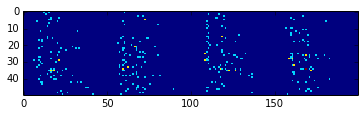

In [6]:
%matplotlib inline
def plot_filter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(30,20))
    n_columns = 3
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")
        
test_image = test_data[:1]
img_filters1, img_filters2 = sess.run([h_conv1,h_conv2], feed_dict={train_x: test_image})

# Show the original image
plt.imshow(np.reshape(test_image, [x_dim, y_dim]), interpolation="nearest")


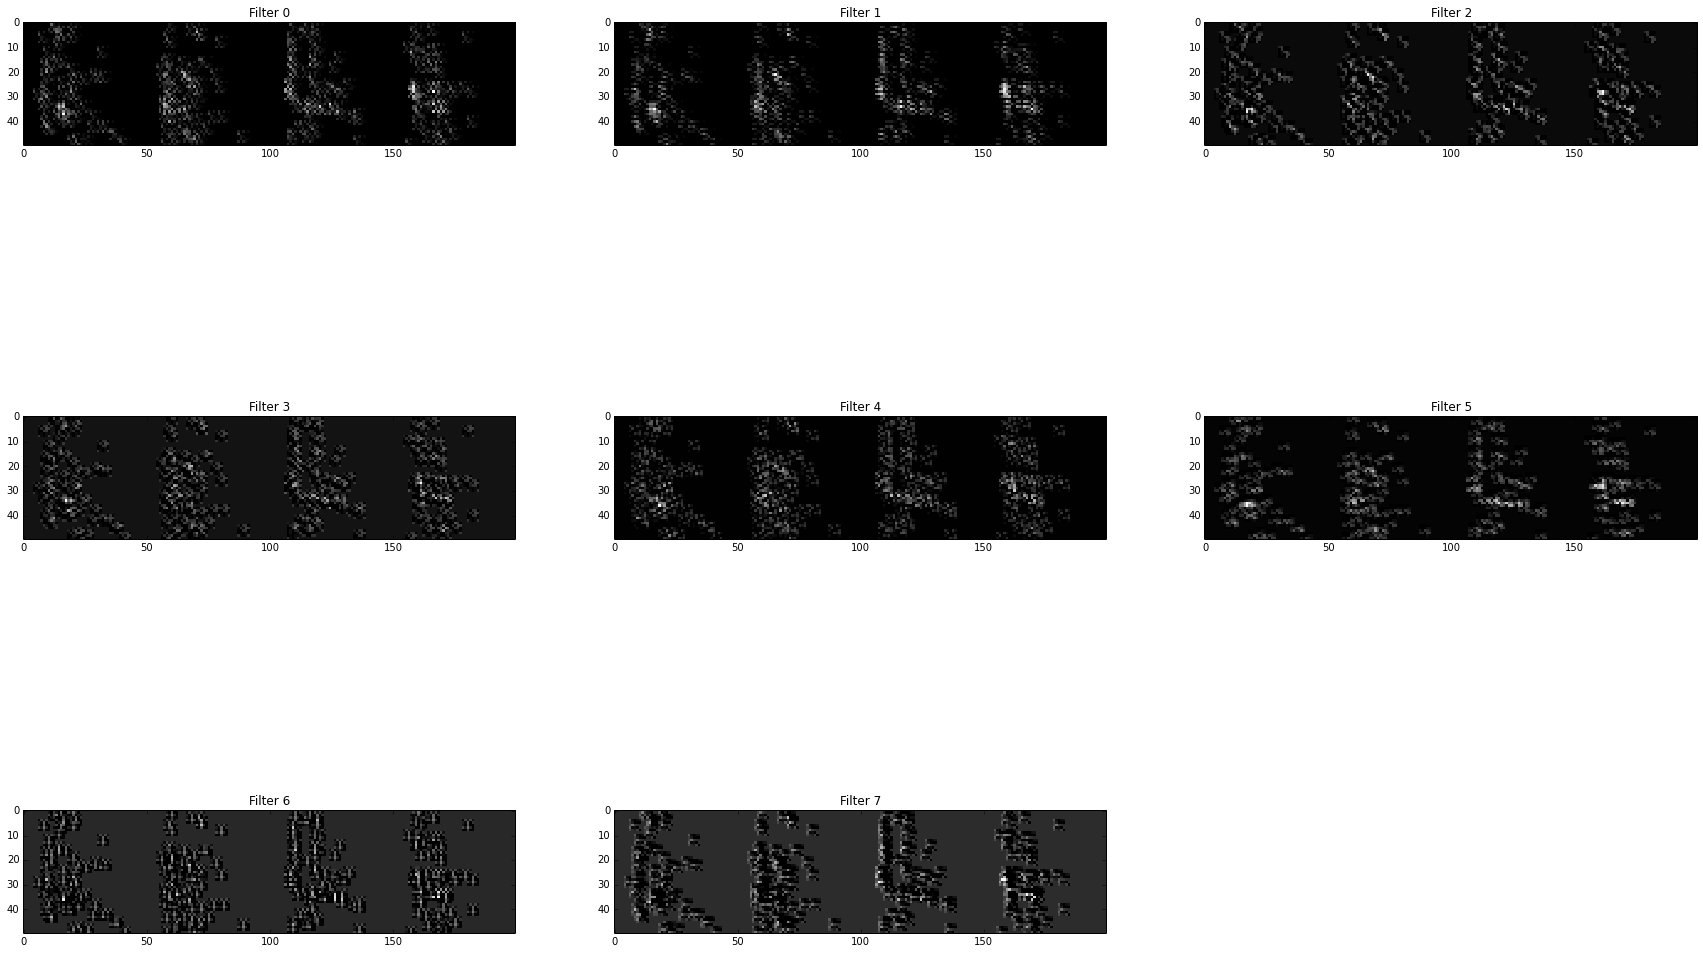

In [7]:
# Show the first convolutional filters
plot_filter(img_filters1)

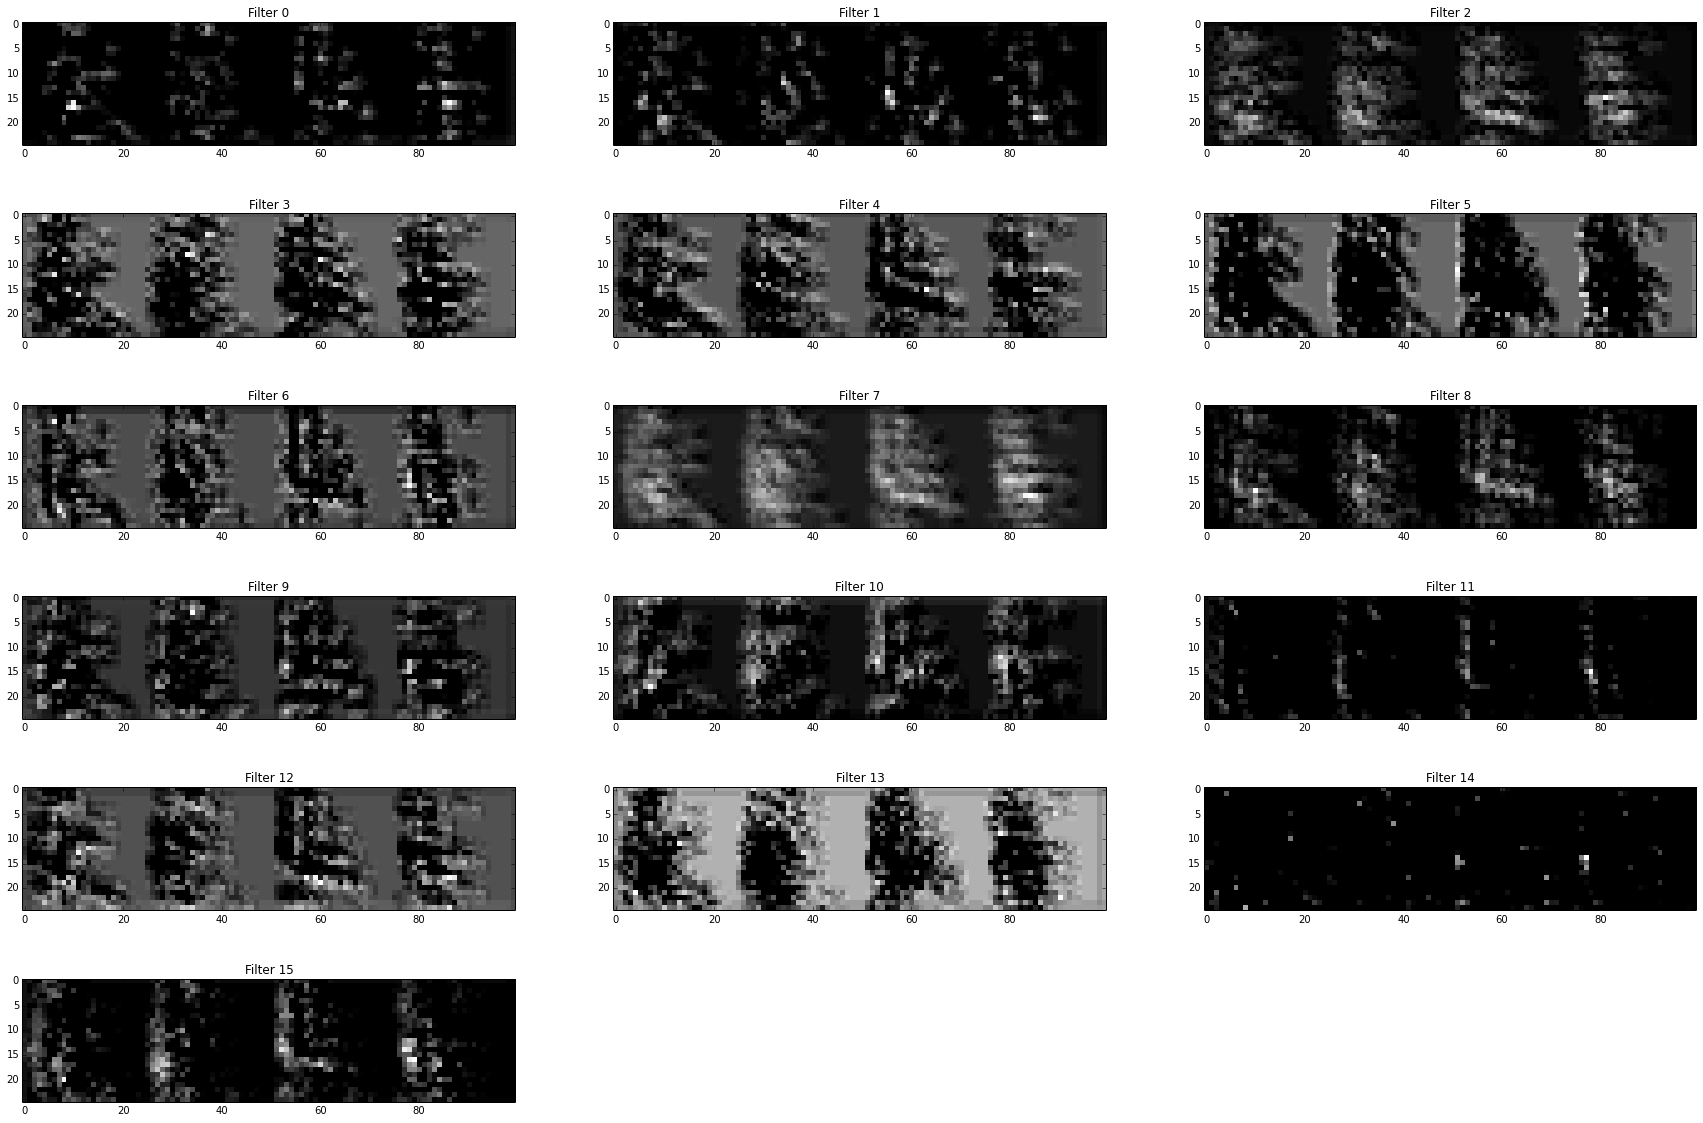

In [8]:
# Show the second convolutional filters
plot_filter(img_filters2)

#################


Provide your responses here



#################